# Bayesian deep learning illustrated
*By: Frédéric Branchaud-Charron*


In this notebook, we will do a quick introduction on Bayesian deep learning.
The material covered here is heavily drawn from the paper in our [Literature review](https://baal.readthedocs.io/en/latest/literature/core-papers.html) section.

In particular, Andrew Gordon Wilson's tutorial and Yarin Gal's papers.


Let me know if you would like more details, less details, if I misunderstood something, etc.

### The posterior distribution

The posterior distribution $p(\theta | D)$ given a dataset $D$ is the distribution from which come the model's parameters. In "regular" deep learning, we make a single draw from this distribution when we finish training and use this set of parameters forever.

In Bayesian deep learning, we draw multiple times from this distribution in order to get a better estimation.

In the figure below, we show the decision function for multiple models. These different models all produce different predictions. The first curve (darker one) will be our **frequentist** model or the model that one would get after training only once.

We will also plot a random point $x=0.6, y=0.75$ to see the effect that this can have when doing prediction.

(0.25, 1.25)

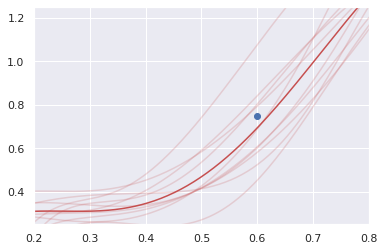

In [46]:
# For this demo, we will use Bezier curves to mimic the decision boundary.
from sklearn.datasets import make_classification
import numpy as np
import seaborn
import bezier
seaborn.set()
N_DRAW = 10
RED = [198/255, 79/255, 79/255]
rng = np.random.RandomState(2021)
x, y = 0.6, 0.75

nodes = np.asfortranarray([
     [0.0, 0.25,  0.5, 0.75, 1.0],
     [0.0, 1.0 , -1.0, 2.0 , 1.5],
])
curve1 = bezier.Curve.from_nodes(nodes)
curves = [curve1]

ax = curve1.plot(num_pts=256,  color=RED)

for _ in range(N_DRAW):
    nodes_ = nodes + rng.randn(*nodes.shape) * .1
    c = bezier.Curve.from_nodes(nodes_)
    curves.append(c)
    _ = c.plot(num_pts=256,  color=RED, ax=ax, alpha=0.2)
ax.scatter(x, y)
ax.set_xlim(0.2, 0.8)
ax.set_ylim(0.25, 1.25)

#### What now?

We now have a visual representation of the posterior distribution but what can we do with it?

By using multiple sets of weights, we can get multiple predictions for each example! The average prediction would be more trusthworthy because we do not rely on a single model, but a variety of models.

We call this **Bayesian model averaging**

$ \text{BMA}(x) = p(y \mid x, {\cal D})= \int p(y \mid x, \theta)p(\theta \mid D) d\theta$


We can visualize this again on  our random point, our first curve acts as a frequentist model that we compare against:

In [47]:
freq_prediction = (curves[0].evaluate(x)[1] - y) > 0

distances = [(c.evaluate(x)[1] - y).item() for c in curves[1:]]
disagree = [(d > 0) != freq_prediction for d in distances]

print(f"{sum(prediction)} estimators disagree with the frequentist model!")

7 estimators disagree with the frequentist model!


**Result**

While this model can be fairly confident on its prediction, the BMA would make this prediction more nuanced as a majority of estimator disagree with it.

### How to do BMA in real life?

While this example is great for explanations, how can we practically use this?

There are several ways of drawing from the posterior distribution:

1. Ensembles
    1. We can train multiple models independtly, each model's parameter are drawn from the posterior.
    2. This is slow and computationnaly expensive, but give better results.
2. MC-Dropout (Gal and Ghahramani, 2016)
    1. We can do multiple forward passes with Dropout activated to perform Bayesian sampling.
    2. This is a popular and fast approach, but is not indicated for out-of-distribution detection.
3. And many more!
    1. Bayesian neural networks, SWAG, etc are all great ways to do BMA, but are not covered here.

#### Modelizing uncertainty

We would like get a number to characterize this disagreement. 
Would the entropy ($H[x]$) of the BMA suffice? Yes and no, the entropy of the BMA stays the same when there is disagreement or when no prediction is confident.

$ H[x] = \frac{1}{C}\sum_c^C p(y_c | x) log(p(y_c | x)) $


BALD (Houlsby et al. 2013) is a better alternative, it is only high when there is disagreement.

$BALD(x) = {\cal I}[y, \theta \mid x, {\cal D}] = {\cal H}[y \mid x, {\cal D}] - E_{p(\theta \mid {\cal D})}[{\cal H}[y \mid x, \theta]]$

This score is especially useful in active learning, where we are looking for the most uncertain examples. A drawback from this score is that it is not interpretable.

BaaL has utilities to run Entropy or BALD on your set of predictions, please check it out!